In [1]:
#Importo as bibliotecas necessárias

import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#Considero o bias (elemento multiplicado por a0)
include_bias = True

#É definida a ordem do polinômio a ser utilizado
model_order = 30

#Passo de aprendizado
alpha = 0.04

#Número de iterações
n_epochs = 1000

In [3]:
#Features criadas, função target e sua versão ruidosa.

#Número de exemplos
M = 100 

#Features criadas
x = 6*np.random.rand(M, 1) - 3

#Função target, com e sem ruído
y = 2 + x + 0.5*x**2 + x**3
y_noisy = y + np.random.randn(M, 1)


#Features e função target para teste
Mtest = 100
x_test = np.linspace(-3, 3, Mtest).reshape(Mtest, 1)
y_test = 2 + x_test + 0.5*x_test**2 + x_test**3 + np.random.randn(Mtest, 1)


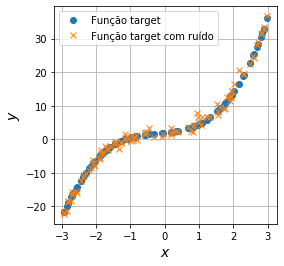

In [5]:
#Gráfico com função target e versão ruidosa
fig = plt.figure(figsize=(4,4))
plt.plot(x, y, 'o', label='Função target')
plt.plot(x, y_noisy, 'x', label='Função target com ruído')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
#Show the plot.
plt.show()

In [7]:
#Crio uma função para calcular o erro quadrático médio
def mse(X, a, y, M):
    Jgd = (1/M)*sum(np.power((y - X.dot(a)), 2))
    return Jgd


In [18]:
#Crio função para executar o algoritmo do batch
def batch(X_train, y_train, X_val, y_val, X_test, y_test, model_order, alpha, n_epochs, a_init):
    
    #Defini o ponto inicial para a melhor época, melhor modelo, norma e mínimo valor do erro
    best_epoch = None
    best_model = None
    norm_hist = np.zeros(n_epochs+1)
    minimum_val_error = float("inf")
    
    #Inicialização aleatória dos pesos
    a = a_init

    #Vetores para armazenar o histórico dos valores dos erros do GD
    Jgd_train = np.zeros(n_epochs+1)
    Jgd_val   = np.zeros(n_epochs+1)
    Jgd_test  = np.zeros(n_epochs+1)
    
    #São calculados os erros iniciais.
    Jgd_train[0] = mse(X_train, a, y_train, len(y_train))
    Jgd_test[0]  = mse(X_test, a, y_test, len(y_test))
    Jgd_val[0]   = mse(X_val, a, y_val, len(y_val))
    
    #Calculado a norma inicial para os pesos inicializados de forma aleatória
    norm_hist[0] = np.linalg.norm(a)
    
    #Inicializo as variáveis utilizadas no loop
    iteration = 0
    error = 1
    
    while iteration < n_epochs:
        
        #É calculado o gradiente para o conjunto de treinamento
        gradients = -2/len(y_train)*X_train.T.dot(y_train - X_train.dot(a))
        
        #O valos dos parâmetros a é calculado
        a = a - alpha * gradients
        
        #É calculado o valor do erro para o conjunto de treinamento
        Jgd_train[iteration+1] = mse(X_train, a, y_train, len(y_train))
        
        #É calculado o erro entre duas iterações consecutivas
        error = np.abs(Jgd_train[iteration+1] - Jgd_train[iteration])
        
        #É calculado o erro para os conjuntos de validação e teste
        Jgd_val[iteration+1] = mse(X_val, a, y_val, len(y_val))
        Jgd_test[iteration+1] = mse(X_test, a, y_test, len(y_test))
        
        #É calculado a norma para a iteração e seu valor é agregado ao vetor
        norm_hist[iteration+1] = np.linalg.norm(a[1:])
        
        #Condição para testar e armazenar o melhor modelo
        if Jgd_val[iteration+1] < minimum_val_error:
            minimum_val_error = Jgd_val[iteration+1]
            best_epoch = iteration
            best_model = a
        
        iteration = iteration + 1
        
    return Jgd_train, Jgd_val, Jgd_test, minimum_val_error, best_epoch, best_model, norm_hist, a

In [19]:
#Divisão dos conjuntos de treinamento e validação (70% treinamento e 30% validação)
x_train, x_val, y_train, y_val = train_test_split(x, y_noisy, test_size=0.7, random_state=42)

In [20]:
#Concatenar os vetores coluna com as features de treinamento elevadas a ordem dos polinômios
X_train = np.ones((len(y_train),1))
for i in range(1, model_order+1):
    X_train = np.c_[X_train, np.power(x_train, i)]

#Escalonamento de features para o conjunto de treinamento
scaler = StandardScaler()
X_train = np.c_[np.ones((len(y_train),1)), scaler.fit_transform(X_train[:,1:])]

#Concatenar os vetores coluna com as features de treinamento elevadas a ordem dos polinômios
X_val = np.ones((len(y_val),1))
for i in range(1, model_order+1):
    X_val = np.c_[X_val, np.power(x_val, i)]

#Escalonamento de features para as do conjunto de validação
X_val = np.c_[np.ones((len(y_val),1)), scaler.transform(X_val[:,1:])]

#Concatenar os vetores coluna com as features de teste elevadas a ordem dos polinômios
X_test = np.ones((len(y_test),1))
for i in range(1, model_order+1):
    X_test = np.c_[X_test, np.power(x_test, i)]

#Escalonamento de features para as de teste
X_test = np.c_[np.ones((len(y_test),1)), scaler.transform(X_test[:,1:])]

#Inicialização de pesos
a_init = np.random.randn(model_order+1, 1)
if(0):
    a_init = np.zeros((model_order+1, 1))
    a_init[0] = 4
    a_init[1] = 4
    a_init[2] = 4
    a_init[3] = 4

In [21]:
#É executado o algoritmo do batch (a função do batch é executada)
Jgd_train, Jgd_val, Jgd_test, minimum_val_error, best_epoch, best_model, norm_hist, a = batch(X_train, y_train, X_val, y_val, X_test, y_test, model_order, alpha, n_epochs, a_init)

a_opt = [1, 0.5, 1]
print('best_epoch:',best_epoch)
print('minimum_val_error:',minimum_val_error)
print('norma:', np.linalg.norm(best_model[1:])/30)
print('norma:', np.linalg.norm(a_opt)/3)

best_epoch: 220
minimum_val_error: 1.9145657533522094
norma: 0.2535719163278706
norma: 0.5


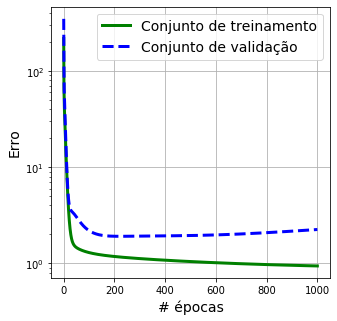

In [23]:
#Erros de treinamento e validação vs. número de épocas
fig = plt.figure(figsize=(5,5))

plt.plot(range(0, n_epochs+1), Jgd_train, "g-", linewidth=3, label="Conjunto de treinamento")
plt.plot(range(0, n_epochs+1), Jgd_val, "b--", linewidth=3, label="Conjunto de validação")
plt.yscale('log')
plt.legend(loc="upper right", fontsize=14)
plt.xlabel('# épocas', fontsize=14)
plt.ylabel("Erro", fontsize=14)
plt.grid()
plt.show()